In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [103]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

In [104]:
df_fraud = df_cct[df_cct["Is Fraud?"] == 1]
df_not_fraud = df_cct[df_cct["Is Fraud?"] == 0]

In [105]:
df_fraud_list = df_fraud.index.tolist()
df_not_fraud_list = df_not_fraud.index.tolist()


## Random subsampling (10% of dataset)

In [106]:
import random

In [107]:
df_fraud_rs_index = random.sample(df_fraud_list, int(len(df_fraud_list)*0.01))
df_fraud_rs = df_fraud.loc[df_fraud_rs_index]

In [108]:
df_not_fraud_rs_index = random.sample(df_not_fraud_list, int(len(df_not_fraud_list)*0.01))
df_not_fraud_rs = df_not_fraud.loc[df_not_fraud_rs_index]

In [109]:
df = pd.concat([df_not_fraud_rs,df_fraud_rs], axis=0).reset_index(drop=True)

## OneHotEncoder

In [110]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df = pd.concat([df, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [111]:
# Pour "day_of_week" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df[["day_of_week"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df = pd.concat([df, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [112]:
selection = ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday','Is Fraud?']

In [113]:
estimators = ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']
df_selec = df[selection]
#df_selec = df_selec[np.isfinite(df_selec).all(1)]
X1 = df_selec[estimators]
y = df_selec["Is Fraud?"]


In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y, 
                                                    train_size = 0.70, test_size = 0.30, random_state = 1, stratify = y)

In [115]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

In [116]:
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', RobustScaler(), ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 'nb_daily_declines_card', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',])
        ])

In [117]:
model = Pipeline(steps = [('pr', preprocessor), ('lr', LogisticRegression(class_weight = {1:0.85, 0:0.15}))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     73072
           1       0.06      0.01      0.02        89

    accuracy                           1.00     73161
   macro avg       0.53      0.51      0.51     73161
weighted avg       1.00      1.00      1.00     73161



In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

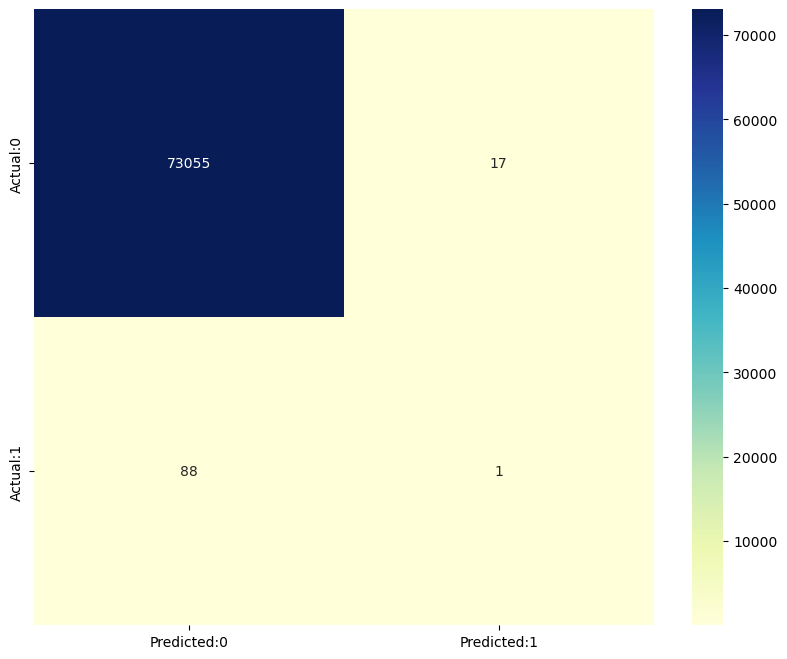

In [120]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [121]:
# print(model.steps[1][1].coef_)
# plt.bar(X1.columns, model.steps[1][1].coef_[0])
# plt.xticks(rotation = -90)
# plt.show()

df_coef = pd.DataFrame(model.steps[1][1].coef_,columns=X1.columns)
df_coef = df_coef.transpose()#.reset_index()
df_coef

,0
Card,0.293473
Month,0.109424
Day,-0.109787
Hours,-0.592569
Amount,0.047227
delta_t_s,-0.688647
delta_t_s_card,-0.308519
amt/daily_income,0.000221
Retired,0.294695
daily_amount,0.059771


In [122]:
import plotly.express as px
px.bar(df_coef)


In [123]:
!pip install shap

In [124]:
import shap
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 73162it [6:27:39,  3.14it/s]                              


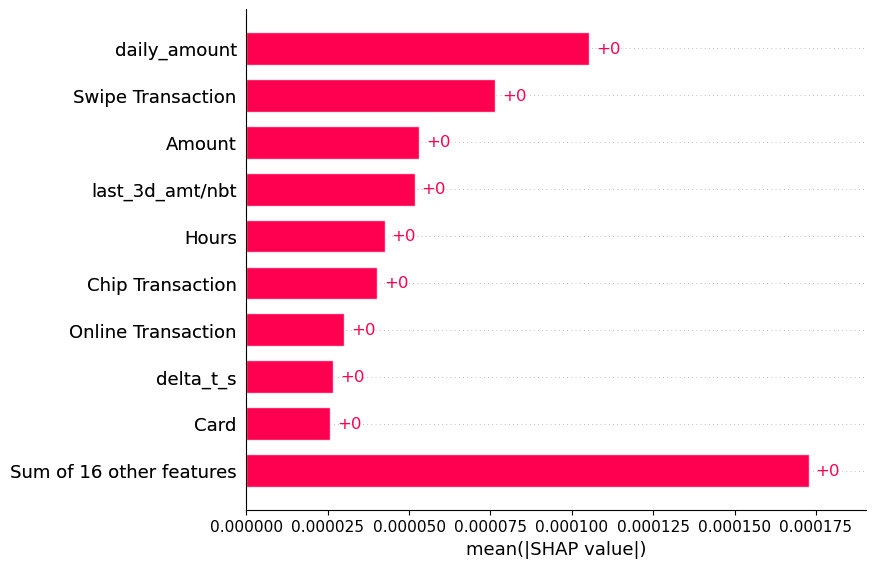

In [127]:
shap.plots.bar(shap_values)